<a href="https://colab.research.google.com/github/yashmehra028/so-fifa/blob/main/so_fifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

In [21]:
def get_players_links(n_pages):
    offset = range(0,60*n_pages,60)
    player_links = []

    for offset_value in offset:
        r = requests.get(f'https://sofifa.com/players?offset={offset_value}')
        all_players_page = bs(r.content)
        tables = all_players_page.select('td.col-name')
        for table in tables:
            a_tag = table.find('a')
            url = a_tag['href']
            if 'player' in url and 'players' not in url:
                player_links.append('https://sofifa.com' + url)

    return player_links

player_links = get_players_links(50)

In [22]:
len(player_links)

3000

In [ ]:
import re

def get_name(player_page):

    name_div = player_page.find('div',attrs={'class':'info'})
    return [('Name',name_div.find('h1').get_text())]

def get_section_box(player_page):

    info_list = []

    for initial_info in player_page.select('section'):
        text = initial_info.get_text()
    
    if 'M' in text:
        text = text.replace('M','')
    if 'K' in text:
        text = text.replace('K','')
    
    pattern = re.compile(r'[+-]\d{1,2}')
    if pattern.findall(text):
        for i in pattern.findall(text):
            text = text.replace(i,'').strip()

    
    pattern_num = re.compile(r'\d+[\.\d+]*')
    pattern_text = re.compile(r'[A-Za-z]+')
    
    num_list = pattern_num.findall(text)
    char_list = pattern_text.findall(text)
    char_list[0] += ' ' + char_list[1]
    char_list.pop(1)

    for i in range(len(num_list)):
        info_list.append((char_list[i],float(num_list[i])))

    return info_list

def get_skills(player_page):

    valid_fields = ['Attacking', 'Skill', 'Movement','Power', 'Mentality', 'Defending', 'Goalkeeping']

    info_list = []
    divs = [i for i in player_page.select('div.card')]

    valid_divs = []
    for i in divs:
        if i.select('h5'):
            if i.select('h5')[0].get_text() in valid_fields:
                valid_divs.append(i)

    
    for i in valid_divs:
        info = [j.get_text().strip() for j in i.select('li')]
        
        for j in info:
            pattern_num = re.compile(r'\d+')
            pattern_text = re.compile(r'[A-Za-z]+\s*[A-Za-z]*')

            try:
                num = pattern_num.findall(j)[0]
                char = pattern_text.findall(j)[0]
                info_list.append((char,float(num)))
                
            except:
                pass


    return info_list


def get_height_weight(player_page):

    info_list = []

    all_text = player_page.find('div',attrs={'class':'meta ellipsis'}).get_text()
    nationality = player_page.find('div',attrs={'class':'meta ellipsis'}).find('a')['title']
    info_list.append(('Nationality',nationality))

    body_measures = ['Age','Height','Weight']

    pattern = re.compile(r'\d+[c|k|y]')
    values = pattern.findall(all_text)

    for i in range(len(values)):
        info_list.append((body_measures[i],float(values[i][:len(values[i])-1])))

    return info_list


def get_player_info(player_link):
    r = requests.get(player_link)
    player_page = bs(r.content)

    a = get_section_box(player_page)
    b = get_name(player_page)
    c = get_skills(player_page)
    d = get_height_weight(player_page)

    return a + b + c + d

In [ ]:
get_player_info('https://sofifa.com/player/1041/javier-zanetti/140041/')

In [23]:
result = []
for link in player_links[:]:
    info_dict = {i[0]:i[1] for i in get_player_info(link)}
    result.append(info_dict)


In [105]:
len(result)

3000

In [159]:
import pandas as pd

df = pd.DataFrame(result)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2948 entries, 0 to 2999
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Overall Rating       2948 non-null   float64
 1   Potential            2948 non-null   float64
 2   Value                2948 non-null   float64
 3   Wage                 2948 non-null   float64
 4   Name                 2948 non-null   object 
 5   Crossing             2948 non-null   float64
 6   Finishing            2948 non-null   float64
 7   Heading Accuracy     2948 non-null   float64
 8   Short Passing        2948 non-null   float64
 9   Volleys              2948 non-null   float64
 10  Dribbling            2948 non-null   float64
 11  Curve                2948 non-null   float64
 12  FK Accuracy          2948 non-null   float64
 13  Long Passing         2948 non-null   float64
 14  Ball Control         2948 non-null   float64
 15  Acceleration         2948 non-null   f

In [161]:
df.drop('Marking',1,inplace=True)
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [110]:
df.to_csv('data.csv')

In [162]:
nations_group = df.groupby('Nationality')

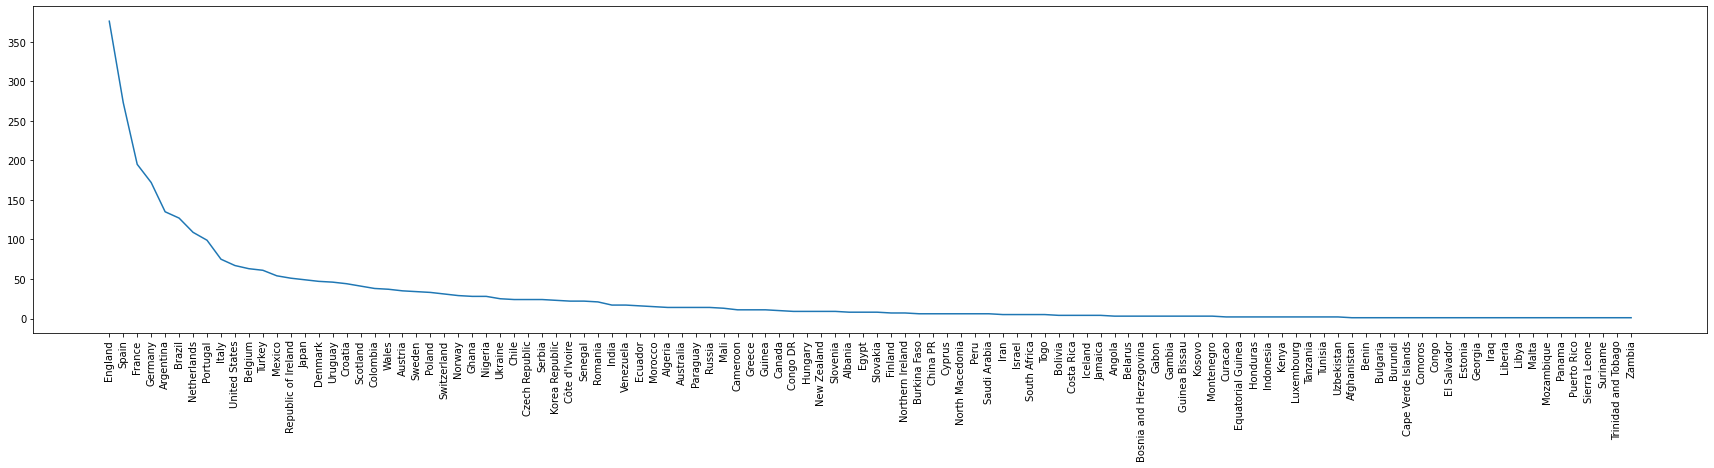

In [167]:
players_by_country = [(country,df1.shape[0]) for country,df1 in nations_group]
players_by_country.sort(key=lambda x:x[1],reverse=True)
countries = [i[0] for i in players_by_country]
num_players = [i[1] for i in players_by_country]

plt.figure(figsize=(30,6))
plt.xticks(rotation = 90)
plt.plot(countries,num_players)

In [113]:
'India' in countries

True

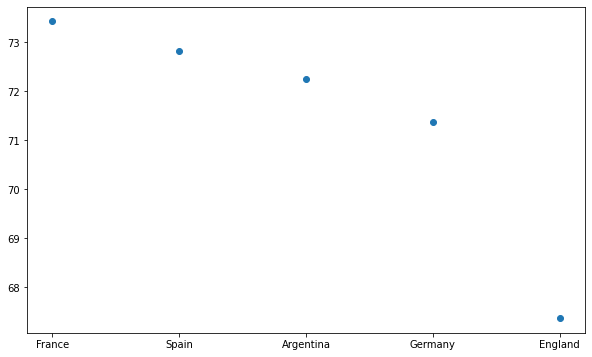

In [165]:
top_countries = countries[0:5]

av_rating = []
for country, df1 in nations_group:
    if country in top_countries:
        av_rating.append((country,df1['Overall Rating'].sum()/len(df1['Overall Rating'])))
    
av_rating.sort(key=lambda x:x[1],reverse=True)

rating = [i[1] for i in av_rating]
temp_countries = [i[0] for i in av_rating]

plt.figure(figsize=(10,6))
plt.scatter(temp_countries,rating)

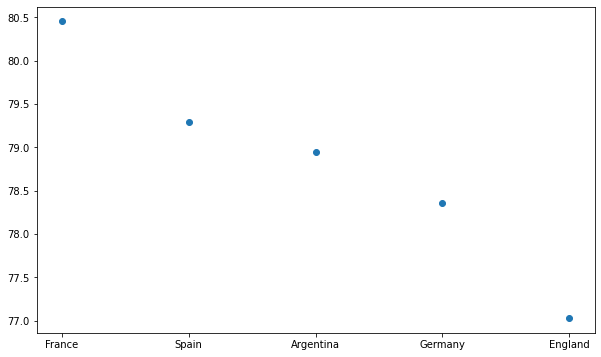

In [115]:
top_countries = countries[0:5]

av_potential = []
for country, df1 in nations_group:
    if country in top_countries:
        av_potential.append((country,df1['Potential'].sum()/len(df1['Potential'])))
    
av_potential.sort(key=lambda x:x[1],reverse=True)

potential = [i[1] for i in av_potential]
temp_countries = [i[0] for i in av_potential]

plt.figure(figsize=(10,6))
plt.scatter(temp_countries,potential)

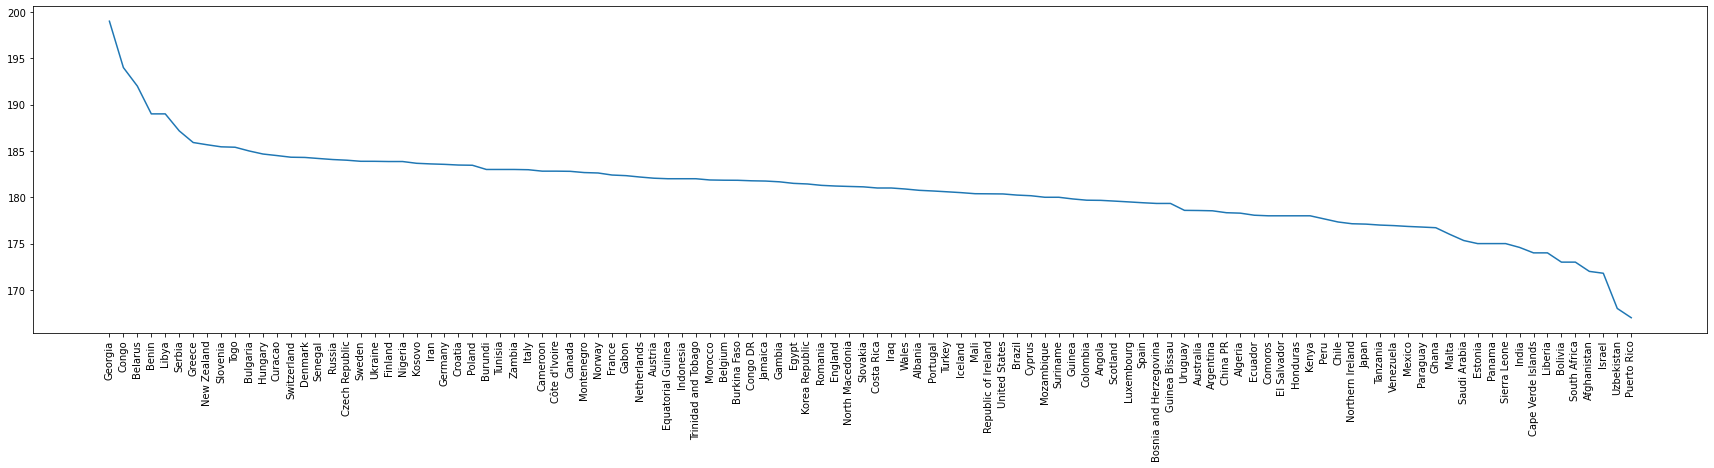

In [168]:
top_countries = countries[:]

av_height = []
for country, df1 in nations_group:
    if country in top_countries:
        av_height.append((country,df1['Height'].sum()/len(df1['Height'])))
    
av_height.sort(key=lambda x:x[1],reverse=True)

height = [i[1] for i in av_height]
temp_countries = [i[0] for i in av_height]

plt.figure(figsize=(30,6))
plt.xticks(rotation = 90)
plt.plot(temp_countries,height)

In [170]:
len(countries)

110

In [ ]:
# #imdb
# import requests
# from bs4 import BeautifulSoup as bs

# def get_movie_links(n_pages):

#     all_movie_links = []

#     url = 'https://www.imdb.com/search/title/?country_of_origin=IN&start=201&ref_=adv_nxt'
#     start_values = range(1,n_pages*50,50)
#     for start in start_values:
#         url = f'https://www.imdb.com/search/title/?country_of_origin=IN&start={start}&ref_=adv_nxt'
#         r = requests.get(url)
#         all_links_page = bs(r.content)
#         h3_tags = all_links_page.select('h3')
#         for tag in h3_tags:
#             try:
#                 movie_url = tag.find('a')['href']
#                 full_url = f'https://www.imdb.com{movie_url}?ref_=adv_li_tt'
#                 all_movie_links.append(full_url)
            
#             except:
#                 pass
        

#     return all_movie_links
# all_links = get_movie_links(30) 